In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torchwi import Tomo2d
from torchwi.io import rsf, CFGParser
from pkrh.torchwi import param_selector, get_land_mask
from SSIM import SSIM
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
EPOCHS = 3000
vmin, vmax = 1.5, 5.0
lr = 4

In [4]:
nx=320
ny=50
h=0.1
shotskip=2

shape = (nx,ny)
meter_to_km=0.001

In [5]:
nshot = 200
ivel = 35000

sxs = (104 + np.arange(nshot))*h
sy = 0.
ry = 0.

In [6]:
rx = np.zeros((nshot,2),dtype=np.int32)

for ishot in range(nshot):
    rx[ishot,0] = 2 + ishot
    rx[ishot,1] = rx[ishot,0] + 100

print("nshot=%d, sy=%s, ry=%s"%(nshot,sy,ry))

nshot=200, sy=0.0, ry=0.0


In [7]:
rcv_mask = np.zeros((nshot,nx),dtype=bool)

for ishot in range(nshot):
    ir0 = rx[ishot,0]
    ir1 = rx[ishot,1]
    rcv_mask[ishot,ir0:ir1] = True

In [8]:
rcv_mask = torch.from_numpy(rcv_mask)

In [9]:
vinit = np.load("./vinit.npy")
vinit.shape = (nx,ny)

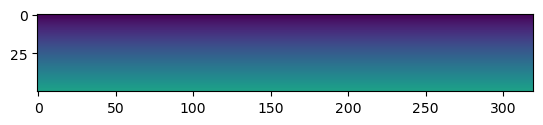

In [10]:
plt.imshow(vinit.T, vmin=1.5, vmax=5.0)

In [11]:
vinit = torch.from_numpy(vinit)

In [12]:
ttime_obs = np.load("../../data/ml_time/time%05d.npy"%ivel)
ttime_obs.shape = (nshot,nx)

In [13]:
#ttime_obs = np.transpose(ttime_obs)

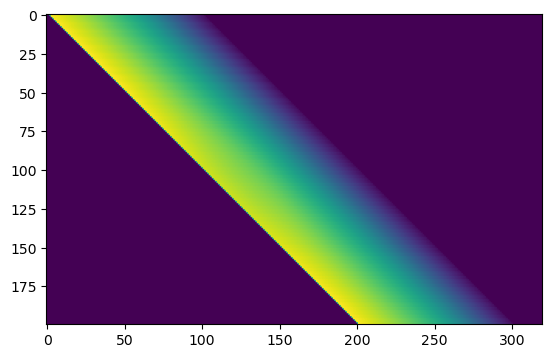

In [14]:
plt.imshow(ttime_obs)

In [15]:
#ttime_obs[0].shape

In [16]:
#plt.plot(ttime_obs[0])

In [17]:
ttime_obs.shape

(200, 320)

In [18]:
ttime_obs = torch.from_numpy(ttime_obs)

In [19]:
vel = param_selector('velocity',vinit,vmin,vmax)
optimizer = torch.optim.LBFGS(vel.parameters(), lr=lr, history_size=20)

In [20]:
def closure():
    # frequency loop
    optimizer.zero_grad()
    
    tomo.factorize(omega, vel())
    ttime = tomo.forward(torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    loss = torch.sum((ttime_obs - ttime)**2)/(nshot*100)
    
    loss.backward()
    tomo.finalize()
    return loss

In [21]:
tomo = Tomo2d(nx,ny,h)
freq = 0.05
vmean = 3.0

In [22]:
alpha = 2*np.pi / (20*h) * vmean
omega = 2.*np.pi*freq - alpha * 1.0j

In [23]:
def traveltime_tomo(ttime_obs, vel, num_epoch=None):
    
    losses = []
    norm_losses = []
    since = time.time()
    
    # main loop
    for itr in range(num_epoch+1):
        
        loss = optimizer.step(closure)

        if itr==0:
            grad = vel.gradient()
            gnorm0 = grad.abs().max().item()
            loss0=loss.item()
        # all freq grad
        #vel.normalize_gradient(gnorm0)
    
        time_elapsed = time.time() - since
        
        losses.append(loss.item())
        norm_losses.append(loss.item()/loss0)
        print('\nitr {}/{} Loss: {:.10f}'.format(itr, num_epoch, loss.item()))
        print('itr {}/{} norm_loss={:.6f}'.format(itr, num_epoch, loss.item()/loss0))
        
        #if itr == 500:
        #    vel().detach().numpy().astype(np.float32).tofile("vel%05d.npy"%itr)
        #    vel.gradient().detach().numpy().astype(np.float32).tofile("grad%05d.npy"%itr)
            
        #if loss.item()/loss0 < 0.001:
        #    break

    print('\nTotal time elapesd of traveltime tomography {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return losses, norm_losses 

In [24]:
losses, norm_losses = traveltime_tomo(ttime_obs, vel, num_epoch=EPOCHS)


itr 0/3000 Loss: 0.0295007564
itr 0/3000 norm_loss=1.000000

itr 1/3000 Loss: 0.0293862335
itr 1/3000 norm_loss=0.996118

itr 2/3000 Loss: 0.0292724576
itr 2/3000 norm_loss=0.992261

itr 3/3000 Loss: 0.0291594267
itr 3/3000 norm_loss=0.988430

itr 4/3000 Loss: 0.0290471260
itr 4/3000 norm_loss=0.984623

itr 5/3000 Loss: 0.0289355591
itr 5/3000 norm_loss=0.980841

itr 6/3000 Loss: 0.0288247075
itr 6/3000 norm_loss=0.977084

itr 7/3000 Loss: 0.0287145730
itr 7/3000 norm_loss=0.973350

itr 8/3000 Loss: 0.0286051426
itr 8/3000 norm_loss=0.969641

itr 9/3000 Loss: 0.0284964144
itr 9/3000 norm_loss=0.965955

itr 10/3000 Loss: 0.0283883791
itr 10/3000 norm_loss=0.962293

itr 11/3000 Loss: 0.0282810312
itr 11/3000 norm_loss=0.958654

itr 12/3000 Loss: 0.0281743631
itr 12/3000 norm_loss=0.955039

itr 13/3000 Loss: 0.0280683693
itr 13/3000 norm_loss=0.951446

itr 14/3000 Loss: 0.0279630441
itr 14/3000 norm_loss=0.947875

itr 15/3000 Loss: 0.0278583802
itr 15/3000 norm_loss=0.944328

itr 16/3000


itr 130/3000 Loss: 0.0191248320
itr 130/3000 norm_loss=0.648283

itr 131/3000 Loss: 0.0190704186
itr 131/3000 norm_loss=0.646438

itr 132/3000 Loss: 0.0190162789
itr 132/3000 norm_loss=0.644603

itr 133/3000 Loss: 0.0189623982
itr 133/3000 norm_loss=0.642777

itr 134/3000 Loss: 0.0189087801
itr 134/3000 norm_loss=0.640959

itr 135/3000 Loss: 0.0188554190
itr 135/3000 norm_loss=0.639150

itr 136/3000 Loss: 0.0188023131
itr 136/3000 norm_loss=0.637350

itr 137/3000 Loss: 0.0187494699
itr 137/3000 norm_loss=0.635559

itr 138/3000 Loss: 0.0186968781
itr 138/3000 norm_loss=0.633776

itr 139/3000 Loss: 0.0186445508
itr 139/3000 norm_loss=0.632002

itr 140/3000 Loss: 0.0185924768
itr 140/3000 norm_loss=0.630237

itr 141/3000 Loss: 0.0185406543
itr 141/3000 norm_loss=0.628481

itr 142/3000 Loss: 0.0184890851
itr 142/3000 norm_loss=0.626733

itr 143/3000 Loss: 0.0184377618
itr 143/3000 norm_loss=0.624993

itr 144/3000 Loss: 0.0183866862
itr 144/3000 norm_loss=0.623262

itr 145/3000 Loss: 0.018


itr 257/3000 Loss: 0.0139197856
itr 257/3000 norm_loss=0.471845

itr 258/3000 Loss: 0.0138892988
itr 258/3000 norm_loss=0.470812

itr 259/3000 Loss: 0.0138589339
itr 259/3000 norm_loss=0.469782

itr 260/3000 Loss: 0.0138286864
itr 260/3000 norm_loss=0.468757

itr 261/3000 Loss: 0.0137985600
itr 261/3000 norm_loss=0.467736

itr 262/3000 Loss: 0.0137685500
itr 262/3000 norm_loss=0.466719

itr 263/3000 Loss: 0.0137386564
itr 263/3000 norm_loss=0.465705

itr 264/3000 Loss: 0.0137088774
itr 264/3000 norm_loss=0.464696

itr 265/3000 Loss: 0.0136792194
itr 265/3000 norm_loss=0.463690

itr 266/3000 Loss: 0.0136496797
itr 266/3000 norm_loss=0.462689

itr 267/3000 Loss: 0.0136202574
itr 267/3000 norm_loss=0.461692

itr 268/3000 Loss: 0.0135909515
itr 268/3000 norm_loss=0.460698

itr 269/3000 Loss: 0.0135617694
itr 269/3000 norm_loss=0.459709

itr 270/3000 Loss: 0.0135327056
itr 270/3000 norm_loss=0.458724

itr 271/3000 Loss: 0.0135037582
itr 271/3000 norm_loss=0.457743

itr 272/3000 Loss: 0.013


itr 384/3000 Loss: 0.0108577237
itr 384/3000 norm_loss=0.368049

itr 385/3000 Loss: 0.0108388690
itr 385/3000 norm_loss=0.367410

itr 386/3000 Loss: 0.0108200824
itr 386/3000 norm_loss=0.366773

itr 387/3000 Loss: 0.0108013581
itr 387/3000 norm_loss=0.366138

itr 388/3000 Loss: 0.0107827000
itr 388/3000 norm_loss=0.365506

itr 389/3000 Loss: 0.0107641043
itr 389/3000 norm_loss=0.364876

itr 390/3000 Loss: 0.0107455663
itr 390/3000 norm_loss=0.364247

itr 391/3000 Loss: 0.0107270880
itr 391/3000 norm_loss=0.363621

itr 392/3000 Loss: 0.0107086757
itr 392/3000 norm_loss=0.362997

itr 393/3000 Loss: 0.0106903287
itr 393/3000 norm_loss=0.362375

itr 394/3000 Loss: 0.0106720459
itr 394/3000 norm_loss=0.361755

itr 395/3000 Loss: 0.0106538273
itr 395/3000 norm_loss=0.361137

itr 396/3000 Loss: 0.0106356693
itr 396/3000 norm_loss=0.360522

itr 397/3000 Loss: 0.0106175682
itr 397/3000 norm_loss=0.359908

itr 398/3000 Loss: 0.0105995238
itr 398/3000 norm_loss=0.359297

itr 399/3000 Loss: 0.010


itr 511/3000 Loss: 0.0088857682
itr 511/3000 norm_loss=0.301205

itr 512/3000 Loss: 0.0088730464
itr 512/3000 norm_loss=0.300774

itr 513/3000 Loss: 0.0088603580
itr 513/3000 norm_loss=0.300343

itr 514/3000 Loss: 0.0088477032
itr 514/3000 norm_loss=0.299914

itr 515/3000 Loss: 0.0088350857
itr 515/3000 norm_loss=0.299487

itr 516/3000 Loss: 0.0088225026
itr 516/3000 norm_loss=0.299060

itr 517/3000 Loss: 0.0088099549
itr 517/3000 norm_loss=0.298635

itr 518/3000 Loss: 0.0087974425
itr 518/3000 norm_loss=0.298211

itr 519/3000 Loss: 0.0087849647
itr 519/3000 norm_loss=0.297788

itr 520/3000 Loss: 0.0087725213
itr 520/3000 norm_loss=0.297366

itr 521/3000 Loss: 0.0087601170
itr 521/3000 norm_loss=0.296946

itr 522/3000 Loss: 0.0087477444
itr 522/3000 norm_loss=0.296526

itr 523/3000 Loss: 0.0087354081
itr 523/3000 norm_loss=0.296108

itr 524/3000 Loss: 0.0087231109
itr 524/3000 norm_loss=0.295691

itr 525/3000 Loss: 0.0087108491
itr 525/3000 norm_loss=0.295275

itr 526/3000 Loss: 0.008


itr 638/3000 Loss: 0.0075174393
itr 638/3000 norm_loss=0.254822

itr 639/3000 Loss: 0.0075083845
itr 639/3000 norm_loss=0.254515

itr 640/3000 Loss: 0.0074993554
itr 640/3000 norm_loss=0.254209

itr 641/3000 Loss: 0.0074903490
itr 641/3000 norm_loss=0.253904

itr 642/3000 Loss: 0.0074813692
itr 642/3000 norm_loss=0.253599

itr 643/3000 Loss: 0.0074724150
itr 643/3000 norm_loss=0.253296

itr 644/3000 Loss: 0.0074634836
itr 644/3000 norm_loss=0.252993

itr 645/3000 Loss: 0.0074545736
itr 645/3000 norm_loss=0.252691

itr 646/3000 Loss: 0.0074456865
itr 646/3000 norm_loss=0.252390

itr 647/3000 Loss: 0.0074368217
itr 647/3000 norm_loss=0.252089

itr 648/3000 Loss: 0.0074279783
itr 648/3000 norm_loss=0.251789

itr 649/3000 Loss: 0.0074191587
itr 649/3000 norm_loss=0.251490

itr 650/3000 Loss: 0.0074103628
itr 650/3000 norm_loss=0.251192

itr 651/3000 Loss: 0.0074015907
itr 651/3000 norm_loss=0.250895

itr 652/3000 Loss: 0.0073928391
itr 652/3000 norm_loss=0.250598

itr 653/3000 Loss: 0.007


itr 765/3000 Loss: 0.0065246033
itr 765/3000 norm_loss=0.221167

itr 766/3000 Loss: 0.0065178503
itr 766/3000 norm_loss=0.220938

itr 767/3000 Loss: 0.0065111108
itr 767/3000 norm_loss=0.220710

itr 768/3000 Loss: 0.0065043853
itr 768/3000 norm_loss=0.220482

itr 769/3000 Loss: 0.0064976737
itr 769/3000 norm_loss=0.220254

itr 770/3000 Loss: 0.0064909761
itr 770/3000 norm_loss=0.220027

itr 771/3000 Loss: 0.0064842924
itr 771/3000 norm_loss=0.219801

itr 772/3000 Loss: 0.0064776223
itr 772/3000 norm_loss=0.219575

itr 773/3000 Loss: 0.0064709671
itr 773/3000 norm_loss=0.219349

itr 774/3000 Loss: 0.0064643282
itr 774/3000 norm_loss=0.219124

itr 775/3000 Loss: 0.0064577013
itr 775/3000 norm_loss=0.218900

itr 776/3000 Loss: 0.0064510889
itr 776/3000 norm_loss=0.218675

itr 777/3000 Loss: 0.0064444891
itr 777/3000 norm_loss=0.218452

itr 778/3000 Loss: 0.0064379028
itr 778/3000 norm_loss=0.218228

itr 779/3000 Loss: 0.0064313295
itr 779/3000 norm_loss=0.218006

itr 780/3000 Loss: 0.006


itr 892/3000 Loss: 0.0057682293
itr 892/3000 norm_loss=0.195528

itr 893/3000 Loss: 0.0057629901
itr 893/3000 norm_loss=0.195351

itr 894/3000 Loss: 0.0057577617
itr 894/3000 norm_loss=0.195173

itr 895/3000 Loss: 0.0057525421
itr 895/3000 norm_loss=0.194996

itr 896/3000 Loss: 0.0057473318
itr 896/3000 norm_loss=0.194820

itr 897/3000 Loss: 0.0057421317
itr 897/3000 norm_loss=0.194644

itr 898/3000 Loss: 0.0057369424
itr 898/3000 norm_loss=0.194468

itr 899/3000 Loss: 0.0057317629
itr 899/3000 norm_loss=0.194292

itr 900/3000 Loss: 0.0057265908
itr 900/3000 norm_loss=0.194117

itr 901/3000 Loss: 0.0057214303
itr 901/3000 norm_loss=0.193942

itr 902/3000 Loss: 0.0057162796
itr 902/3000 norm_loss=0.193767

itr 903/3000 Loss: 0.0057111373
itr 903/3000 norm_loss=0.193593

itr 904/3000 Loss: 0.0057060053
itr 904/3000 norm_loss=0.193419

itr 905/3000 Loss: 0.0057008835
itr 905/3000 norm_loss=0.193245

itr 906/3000 Loss: 0.0056957724
itr 906/3000 norm_loss=0.193072

itr 907/3000 Loss: 0.005


itr 1018/3000 Loss: 0.0051794588
itr 1018/3000 norm_loss=0.175570

itr 1019/3000 Loss: 0.0051753023
itr 1019/3000 norm_loss=0.175429

itr 1020/3000 Loss: 0.0051711542
itr 1020/3000 norm_loss=0.175289

itr 1021/3000 Loss: 0.0051670126
itr 1021/3000 norm_loss=0.175148

itr 1022/3000 Loss: 0.0051628775
itr 1022/3000 norm_loss=0.175008

itr 1023/3000 Loss: 0.0051587494
itr 1023/3000 norm_loss=0.174868

itr 1024/3000 Loss: 0.0051546288
itr 1024/3000 norm_loss=0.174729

itr 1025/3000 Loss: 0.0051505151
itr 1025/3000 norm_loss=0.174589

itr 1026/3000 Loss: 0.0051464075
itr 1026/3000 norm_loss=0.174450

itr 1027/3000 Loss: 0.0051423064
itr 1027/3000 norm_loss=0.174311

itr 1028/3000 Loss: 0.0051382128
itr 1028/3000 norm_loss=0.174172

itr 1029/3000 Loss: 0.0051341252
itr 1029/3000 norm_loss=0.174034

itr 1030/3000 Loss: 0.0051300447
itr 1030/3000 norm_loss=0.173895

itr 1031/3000 Loss: 0.0051259710
itr 1031/3000 norm_loss=0.173757

itr 1032/3000 Loss: 0.0051219058
itr 1032/3000 norm_loss=0.17


itr 1141/3000 Loss: 0.0047169593
itr 1141/3000 norm_loss=0.159893

itr 1142/3000 Loss: 0.0047135721
itr 1142/3000 norm_loss=0.159778

itr 1143/3000 Loss: 0.0047101900
itr 1143/3000 norm_loss=0.159663

itr 1144/3000 Loss: 0.0047068121
itr 1144/3000 norm_loss=0.159549

itr 1145/3000 Loss: 0.0047034402
itr 1145/3000 norm_loss=0.159435

itr 1146/3000 Loss: 0.0047000726
itr 1146/3000 norm_loss=0.159320

itr 1147/3000 Loss: 0.0046967110
itr 1147/3000 norm_loss=0.159206

itr 1148/3000 Loss: 0.0046933540
itr 1148/3000 norm_loss=0.159093

itr 1149/3000 Loss: 0.0046900040
itr 1149/3000 norm_loss=0.158979

itr 1150/3000 Loss: 0.0046866606
itr 1150/3000 norm_loss=0.158866

itr 1151/3000 Loss: 0.0046833218
itr 1151/3000 norm_loss=0.158753

itr 1152/3000 Loss: 0.0046799891
itr 1152/3000 norm_loss=0.158640

itr 1153/3000 Loss: 0.0046766605
itr 1153/3000 norm_loss=0.158527

itr 1154/3000 Loss: 0.0046733376
itr 1154/3000 norm_loss=0.158414

itr 1155/3000 Loss: 0.0046700202
itr 1155/3000 norm_loss=0.15


itr 1264/3000 Loss: 0.0043373634
itr 1264/3000 norm_loss=0.147025

itr 1265/3000 Loss: 0.0043345541
itr 1265/3000 norm_loss=0.146930

itr 1266/3000 Loss: 0.0043317480
itr 1266/3000 norm_loss=0.146835

itr 1267/3000 Loss: 0.0043289466
itr 1267/3000 norm_loss=0.146740

itr 1268/3000 Loss: 0.0043261489
itr 1268/3000 norm_loss=0.146645

itr 1269/3000 Loss: 0.0043233559
itr 1269/3000 norm_loss=0.146551

itr 1270/3000 Loss: 0.0043205656
itr 1270/3000 norm_loss=0.146456

itr 1271/3000 Loss: 0.0043177800
itr 1271/3000 norm_loss=0.146362

itr 1272/3000 Loss: 0.0043149977
itr 1272/3000 norm_loss=0.146267

itr 1273/3000 Loss: 0.0043122200
itr 1273/3000 norm_loss=0.146173

itr 1274/3000 Loss: 0.0043094461
itr 1274/3000 norm_loss=0.146079

itr 1275/3000 Loss: 0.0043066763
itr 1275/3000 norm_loss=0.145985

itr 1276/3000 Loss: 0.0043039103
itr 1276/3000 norm_loss=0.145892

itr 1277/3000 Loss: 0.0043011485
itr 1277/3000 norm_loss=0.145798

itr 1278/3000 Loss: 0.0042983904
itr 1278/3000 norm_loss=0.14


itr 1387/3000 Loss: 0.0040203254
itr 1387/3000 norm_loss=0.136279

itr 1388/3000 Loss: 0.0040179635
itr 1388/3000 norm_loss=0.136199

itr 1389/3000 Loss: 0.0040156054
itr 1389/3000 norm_loss=0.136119

itr 1390/3000 Loss: 0.0040132506
itr 1390/3000 norm_loss=0.136039

itr 1391/3000 Loss: 0.0040108985
itr 1391/3000 norm_loss=0.135959

itr 1392/3000 Loss: 0.0040085497
itr 1392/3000 norm_loss=0.135880

itr 1393/3000 Loss: 0.0040062037
itr 1393/3000 norm_loss=0.135800

itr 1394/3000 Loss: 0.0040038615
itr 1394/3000 norm_loss=0.135721

itr 1395/3000 Loss: 0.0040015220
itr 1395/3000 norm_loss=0.135641

itr 1396/3000 Loss: 0.0039991857
itr 1396/3000 norm_loss=0.135562

itr 1397/3000 Loss: 0.0039968533
itr 1397/3000 norm_loss=0.135483

itr 1398/3000 Loss: 0.0039945235
itr 1398/3000 norm_loss=0.135404

itr 1399/3000 Loss: 0.0039921966
itr 1399/3000 norm_loss=0.135325

itr 1400/3000 Loss: 0.0039898725
itr 1400/3000 norm_loss=0.135246

itr 1401/3000 Loss: 0.0039875517
itr 1401/3000 norm_loss=0.13


itr 1510/3000 Loss: 0.0037519324
itr 1510/3000 norm_loss=0.127181

itr 1511/3000 Loss: 0.0037499198
itr 1511/3000 norm_loss=0.127113

itr 1512/3000 Loss: 0.0037479096
itr 1512/3000 norm_loss=0.127045

itr 1513/3000 Loss: 0.0037459019
itr 1513/3000 norm_loss=0.126976

itr 1514/3000 Loss: 0.0037438960
itr 1514/3000 norm_loss=0.126908

itr 1515/3000 Loss: 0.0037418930
itr 1515/3000 norm_loss=0.126841

itr 1516/3000 Loss: 0.0037398934
itr 1516/3000 norm_loss=0.126773

itr 1517/3000 Loss: 0.0037378948
itr 1517/3000 norm_loss=0.126705

itr 1518/3000 Loss: 0.0037358985
itr 1518/3000 norm_loss=0.126637

itr 1519/3000 Loss: 0.0037339062
itr 1519/3000 norm_loss=0.126570

itr 1520/3000 Loss: 0.0037319148
itr 1520/3000 norm_loss=0.126502

itr 1521/3000 Loss: 0.0037299262
itr 1521/3000 norm_loss=0.126435

itr 1522/3000 Loss: 0.0037279408
itr 1522/3000 norm_loss=0.126368

itr 1523/3000 Loss: 0.0037259576
itr 1523/3000 norm_loss=0.126300

itr 1524/3000 Loss: 0.0037239764
itr 1524/3000 norm_loss=0.12


itr 1633/3000 Loss: 0.0035219006
itr 1633/3000 norm_loss=0.119383

itr 1634/3000 Loss: 0.0035201667
itr 1634/3000 norm_loss=0.119325

itr 1635/3000 Loss: 0.0035184342
itr 1635/3000 norm_loss=0.119266

itr 1636/3000 Loss: 0.0035167045
itr 1636/3000 norm_loss=0.119207

itr 1637/3000 Loss: 0.0035149769
itr 1637/3000 norm_loss=0.119149

itr 1638/3000 Loss: 0.0035132507
itr 1638/3000 norm_loss=0.119090

itr 1639/3000 Loss: 0.0035115269
itr 1639/3000 norm_loss=0.119032

itr 1640/3000 Loss: 0.0035098048
itr 1640/3000 norm_loss=0.118973

itr 1641/3000 Loss: 0.0035080849
itr 1641/3000 norm_loss=0.118915

itr 1642/3000 Loss: 0.0035063676
itr 1642/3000 norm_loss=0.118857

itr 1643/3000 Loss: 0.0035046516
itr 1643/3000 norm_loss=0.118799

itr 1644/3000 Loss: 0.0035029377
itr 1644/3000 norm_loss=0.118741

itr 1645/3000 Loss: 0.0035012253
itr 1645/3000 norm_loss=0.118683

itr 1646/3000 Loss: 0.0034995156
itr 1646/3000 norm_loss=0.118625

itr 1647/3000 Loss: 0.0034978080
itr 1647/3000 norm_loss=0.11


itr 1756/3000 Loss: 0.0033229378
itr 1756/3000 norm_loss=0.112639

itr 1757/3000 Loss: 0.0033214302
itr 1757/3000 norm_loss=0.112588

itr 1758/3000 Loss: 0.0033199242
itr 1758/3000 norm_loss=0.112537

itr 1759/3000 Loss: 0.0033184204
itr 1759/3000 norm_loss=0.112486

itr 1760/3000 Loss: 0.0033169182
itr 1760/3000 norm_loss=0.112435

itr 1761/3000 Loss: 0.0033154176
itr 1761/3000 norm_loss=0.112384

itr 1762/3000 Loss: 0.0033139186
itr 1762/3000 norm_loss=0.112333

itr 1763/3000 Loss: 0.0033124215
itr 1763/3000 norm_loss=0.112283

itr 1764/3000 Loss: 0.0033109260
itr 1764/3000 norm_loss=0.112232

itr 1765/3000 Loss: 0.0033094322
itr 1765/3000 norm_loss=0.112181

itr 1766/3000 Loss: 0.0033079400
itr 1766/3000 norm_loss=0.112131

itr 1767/3000 Loss: 0.0033064499
itr 1767/3000 norm_loss=0.112080

itr 1768/3000 Loss: 0.0033049614
itr 1768/3000 norm_loss=0.112030

itr 1769/3000 Loss: 0.0033034747
itr 1769/3000 norm_loss=0.111979

itr 1770/3000 Loss: 0.0033019891
itr 1770/3000 norm_loss=0.11


itr 1879/3000 Loss: 0.0031494198
itr 1879/3000 norm_loss=0.106757

itr 1880/3000 Loss: 0.0031481013
itr 1880/3000 norm_loss=0.106713

itr 1881/3000 Loss: 0.0031467832
itr 1881/3000 norm_loss=0.106668

itr 1882/3000 Loss: 0.0031454675
itr 1882/3000 norm_loss=0.106623

itr 1883/3000 Loss: 0.0031441529
itr 1883/3000 norm_loss=0.106579

itr 1884/3000 Loss: 0.0031428395
itr 1884/3000 norm_loss=0.106534

itr 1885/3000 Loss: 0.0031415271
itr 1885/3000 norm_loss=0.106490

itr 1886/3000 Loss: 0.0031402169
itr 1886/3000 norm_loss=0.106445

itr 1887/3000 Loss: 0.0031389073
itr 1887/3000 norm_loss=0.106401

itr 1888/3000 Loss: 0.0031375992
itr 1888/3000 norm_loss=0.106357

itr 1889/3000 Loss: 0.0031362933
itr 1889/3000 norm_loss=0.106312

itr 1890/3000 Loss: 0.0031349875
itr 1890/3000 norm_loss=0.106268

itr 1891/3000 Loss: 0.0031336842
itr 1891/3000 norm_loss=0.106224

itr 1892/3000 Loss: 0.0031323822
itr 1892/3000 norm_loss=0.106180

itr 1893/3000 Loss: 0.0031310807
itr 1893/3000 norm_loss=0.10


itr 2002/3000 Loss: 0.0029970536
itr 2002/3000 norm_loss=0.101592

itr 2003/3000 Loss: 0.0029958913
itr 2003/3000 norm_loss=0.101553

itr 2004/3000 Loss: 0.0029947299
itr 2004/3000 norm_loss=0.101514

itr 2005/3000 Loss: 0.0029935704
itr 2005/3000 norm_loss=0.101474

itr 2006/3000 Loss: 0.0029924114
itr 2006/3000 norm_loss=0.101435

itr 2007/3000 Loss: 0.0029912540
itr 2007/3000 norm_loss=0.101396

itr 2008/3000 Loss: 0.0029900975
itr 2008/3000 norm_loss=0.101357

itr 2009/3000 Loss: 0.0029889422
itr 2009/3000 norm_loss=0.101317

itr 2010/3000 Loss: 0.0029877876
itr 2010/3000 norm_loss=0.101278

itr 2011/3000 Loss: 0.0029866348
itr 2011/3000 norm_loss=0.101239

itr 2012/3000 Loss: 0.0029854828
itr 2012/3000 norm_loss=0.101200

itr 2013/3000 Loss: 0.0029843324
itr 2013/3000 norm_loss=0.101161

itr 2014/3000 Loss: 0.0029831822
itr 2014/3000 norm_loss=0.101122

itr 2015/3000 Loss: 0.0029820343
itr 2015/3000 norm_loss=0.101083

itr 2016/3000 Loss: 0.0029808867
itr 2016/3000 norm_loss=0.10


itr 2125/3000 Loss: 0.0028626288
itr 2125/3000 norm_loss=0.097036

itr 2126/3000 Loss: 0.0028616027
itr 2126/3000 norm_loss=0.097001

itr 2127/3000 Loss: 0.0028605773
itr 2127/3000 norm_loss=0.096966

itr 2128/3000 Loss: 0.0028595540
itr 2128/3000 norm_loss=0.096932

itr 2129/3000 Loss: 0.0028585307
itr 2129/3000 norm_loss=0.096897

itr 2130/3000 Loss: 0.0028575088
itr 2130/3000 norm_loss=0.096862

itr 2131/3000 Loss: 0.0028564881
itr 2131/3000 norm_loss=0.096828

itr 2132/3000 Loss: 0.0028554681
itr 2132/3000 norm_loss=0.096793

itr 2133/3000 Loss: 0.0028544490
itr 2133/3000 norm_loss=0.096759

itr 2134/3000 Loss: 0.0028534306
itr 2134/3000 norm_loss=0.096724

itr 2135/3000 Loss: 0.0028524136
itr 2135/3000 norm_loss=0.096690

itr 2136/3000 Loss: 0.0028513973
itr 2136/3000 norm_loss=0.096655

itr 2137/3000 Loss: 0.0028503821
itr 2137/3000 norm_loss=0.096621

itr 2138/3000 Loss: 0.0028493679
itr 2138/3000 norm_loss=0.096586

itr 2139/3000 Loss: 0.0028483546
itr 2139/3000 norm_loss=0.09


itr 2248/3000 Loss: 0.0027434966
itr 2248/3000 norm_loss=0.092997

itr 2249/3000 Loss: 0.0027425832
itr 2249/3000 norm_loss=0.092967

itr 2250/3000 Loss: 0.0027416707
itr 2250/3000 norm_loss=0.092936

itr 2251/3000 Loss: 0.0027407592
itr 2251/3000 norm_loss=0.092905

itr 2252/3000 Loss: 0.0027398488
itr 2252/3000 norm_loss=0.092874

itr 2253/3000 Loss: 0.0027389391
itr 2253/3000 norm_loss=0.092843

itr 2254/3000 Loss: 0.0027380302
itr 2254/3000 norm_loss=0.092812

itr 2255/3000 Loss: 0.0027371219
itr 2255/3000 norm_loss=0.092781

itr 2256/3000 Loss: 0.0027362145
itr 2256/3000 norm_loss=0.092751

itr 2257/3000 Loss: 0.0027353081
itr 2257/3000 norm_loss=0.092720

itr 2258/3000 Loss: 0.0027344024
itr 2258/3000 norm_loss=0.092689

itr 2259/3000 Loss: 0.0027334972
itr 2259/3000 norm_loss=0.092659

itr 2260/3000 Loss: 0.0027325936
itr 2260/3000 norm_loss=0.092628

itr 2261/3000 Loss: 0.0027316902
itr 2261/3000 norm_loss=0.092597

itr 2262/3000 Loss: 0.0027307877
itr 2262/3000 norm_loss=0.09


itr 2371/3000 Loss: 0.0026371335
itr 2371/3000 norm_loss=0.089392

itr 2372/3000 Loss: 0.0026363160
itr 2372/3000 norm_loss=0.089364

itr 2373/3000 Loss: 0.0026354983
itr 2373/3000 norm_loss=0.089337

itr 2374/3000 Loss: 0.0026346820
itr 2374/3000 norm_loss=0.089309

itr 2375/3000 Loss: 0.0026338662
itr 2375/3000 norm_loss=0.089281

itr 2376/3000 Loss: 0.0026330510
itr 2376/3000 norm_loss=0.089254

itr 2377/3000 Loss: 0.0026322366
itr 2377/3000 norm_loss=0.089226

itr 2378/3000 Loss: 0.0026314228
itr 2378/3000 norm_loss=0.089198

itr 2379/3000 Loss: 0.0026306098
itr 2379/3000 norm_loss=0.089171

itr 2380/3000 Loss: 0.0026297974
itr 2380/3000 norm_loss=0.089143

itr 2381/3000 Loss: 0.0026289860
itr 2381/3000 norm_loss=0.089116

itr 2382/3000 Loss: 0.0026281753
itr 2382/3000 norm_loss=0.089088

itr 2383/3000 Loss: 0.0026273651
itr 2383/3000 norm_loss=0.089061

itr 2384/3000 Loss: 0.0026265557
itr 2384/3000 norm_loss=0.089034

itr 2385/3000 Loss: 0.0026257474
itr 2385/3000 norm_loss=0.08


itr 2494/3000 Loss: 0.0025415809
itr 2494/3000 norm_loss=0.086153

itr 2495/3000 Loss: 0.0025408436
itr 2495/3000 norm_loss=0.086128

itr 2496/3000 Loss: 0.0025401074
itr 2496/3000 norm_loss=0.086103

itr 2497/3000 Loss: 0.0025393707
itr 2497/3000 norm_loss=0.086078

itr 2498/3000 Loss: 0.0025386356
itr 2498/3000 norm_loss=0.086053

itr 2499/3000 Loss: 0.0025379008
itr 2499/3000 norm_loss=0.086028

itr 2500/3000 Loss: 0.0025371667
itr 2500/3000 norm_loss=0.086003

itr 2501/3000 Loss: 0.0025364331
itr 2501/3000 norm_loss=0.085979

itr 2502/3000 Loss: 0.0025357001
itr 2502/3000 norm_loss=0.085954

itr 2503/3000 Loss: 0.0025349671
itr 2503/3000 norm_loss=0.085929

itr 2504/3000 Loss: 0.0025342354
itr 2504/3000 norm_loss=0.085904

itr 2505/3000 Loss: 0.0025335047
itr 2505/3000 norm_loss=0.085879

itr 2506/3000 Loss: 0.0025327739
itr 2506/3000 norm_loss=0.085855

itr 2507/3000 Loss: 0.0025320440
itr 2507/3000 norm_loss=0.085830

itr 2508/3000 Loss: 0.0025313145
itr 2508/3000 norm_loss=0.08


itr 2617/3000 Loss: 0.0024552436
itr 2617/3000 norm_loss=0.083226

itr 2618/3000 Loss: 0.0024545763
itr 2618/3000 norm_loss=0.083204

itr 2619/3000 Loss: 0.0024539090
itr 2619/3000 norm_loss=0.083181

itr 2620/3000 Loss: 0.0024532424
itr 2620/3000 norm_loss=0.083159

itr 2621/3000 Loss: 0.0024525765
itr 2621/3000 norm_loss=0.083136

itr 2622/3000 Loss: 0.0024519111
itr 2622/3000 norm_loss=0.083113

itr 2623/3000 Loss: 0.0024512459
itr 2623/3000 norm_loss=0.083091

itr 2624/3000 Loss: 0.0024505814
itr 2624/3000 norm_loss=0.083068

itr 2625/3000 Loss: 0.0024499174
itr 2625/3000 norm_loss=0.083046

itr 2626/3000 Loss: 0.0024492543
itr 2626/3000 norm_loss=0.083023

itr 2627/3000 Loss: 0.0024485912
itr 2627/3000 norm_loss=0.083001

itr 2628/3000 Loss: 0.0024479285
itr 2628/3000 norm_loss=0.082979

itr 2629/3000 Loss: 0.0024472668
itr 2629/3000 norm_loss=0.082956

itr 2630/3000 Loss: 0.0024466056
itr 2630/3000 norm_loss=0.082934

itr 2631/3000 Loss: 0.0024459446
itr 2631/3000 norm_loss=0.08


itr 2740/3000 Loss: 0.0024273556
itr 2740/3000 norm_loss=0.082281

itr 2741/3000 Loss: 0.0024273556
itr 2741/3000 norm_loss=0.082281

itr 2742/3000 Loss: 0.0024273556
itr 2742/3000 norm_loss=0.082281

itr 2743/3000 Loss: 0.0024273556
itr 2743/3000 norm_loss=0.082281

itr 2744/3000 Loss: 0.0024273556
itr 2744/3000 norm_loss=0.082281

itr 2745/3000 Loss: 0.0024273556
itr 2745/3000 norm_loss=0.082281

itr 2746/3000 Loss: 0.0024273556
itr 2746/3000 norm_loss=0.082281

itr 2747/3000 Loss: 0.0024273556
itr 2747/3000 norm_loss=0.082281

itr 2748/3000 Loss: 0.0024273556
itr 2748/3000 norm_loss=0.082281

itr 2749/3000 Loss: 0.0024273556
itr 2749/3000 norm_loss=0.082281

itr 2750/3000 Loss: 0.0024273556
itr 2750/3000 norm_loss=0.082281

itr 2751/3000 Loss: 0.0024273556
itr 2751/3000 norm_loss=0.082281

itr 2752/3000 Loss: 0.0024273556
itr 2752/3000 norm_loss=0.082281

itr 2753/3000 Loss: 0.0024273556
itr 2753/3000 norm_loss=0.082281

itr 2754/3000 Loss: 0.0024273556
itr 2754/3000 norm_loss=0.08


itr 2863/3000 Loss: 0.0024273556
itr 2863/3000 norm_loss=0.082281

itr 2864/3000 Loss: 0.0024273556
itr 2864/3000 norm_loss=0.082281

itr 2865/3000 Loss: 0.0024273556
itr 2865/3000 norm_loss=0.082281

itr 2866/3000 Loss: 0.0024273556
itr 2866/3000 norm_loss=0.082281

itr 2867/3000 Loss: 0.0024273556
itr 2867/3000 norm_loss=0.082281

itr 2868/3000 Loss: 0.0024273556
itr 2868/3000 norm_loss=0.082281

itr 2869/3000 Loss: 0.0024273556
itr 2869/3000 norm_loss=0.082281

itr 2870/3000 Loss: 0.0024273556
itr 2870/3000 norm_loss=0.082281

itr 2871/3000 Loss: 0.0024273556
itr 2871/3000 norm_loss=0.082281

itr 2872/3000 Loss: 0.0024273556
itr 2872/3000 norm_loss=0.082281

itr 2873/3000 Loss: 0.0024273556
itr 2873/3000 norm_loss=0.082281

itr 2874/3000 Loss: 0.0024273556
itr 2874/3000 norm_loss=0.082281

itr 2875/3000 Loss: 0.0024273556
itr 2875/3000 norm_loss=0.082281

itr 2876/3000 Loss: 0.0024273556
itr 2876/3000 norm_loss=0.082281

itr 2877/3000 Loss: 0.0024273556
itr 2877/3000 norm_loss=0.08


itr 2986/3000 Loss: 0.0024273556
itr 2986/3000 norm_loss=0.082281

itr 2987/3000 Loss: 0.0024273556
itr 2987/3000 norm_loss=0.082281

itr 2988/3000 Loss: 0.0024273556
itr 2988/3000 norm_loss=0.082281

itr 2989/3000 Loss: 0.0024273556
itr 2989/3000 norm_loss=0.082281

itr 2990/3000 Loss: 0.0024273556
itr 2990/3000 norm_loss=0.082281

itr 2991/3000 Loss: 0.0024273556
itr 2991/3000 norm_loss=0.082281

itr 2992/3000 Loss: 0.0024273556
itr 2992/3000 norm_loss=0.082281

itr 2993/3000 Loss: 0.0024273556
itr 2993/3000 norm_loss=0.082281

itr 2994/3000 Loss: 0.0024273556
itr 2994/3000 norm_loss=0.082281

itr 2995/3000 Loss: 0.0024273556
itr 2995/3000 norm_loss=0.082281

itr 2996/3000 Loss: 0.0024273556
itr 2996/3000 norm_loss=0.082281

itr 2997/3000 Loss: 0.0024273556
itr 2997/3000 norm_loss=0.082281

itr 2998/3000 Loss: 0.0024273556
itr 2998/3000 norm_loss=0.082281

itr 2999/3000 Loss: 0.0024273556
itr 2999/3000 norm_loss=0.082281

itr 3000/3000 Loss: 0.0024273556
itr 3000/3000 norm_loss=0.08

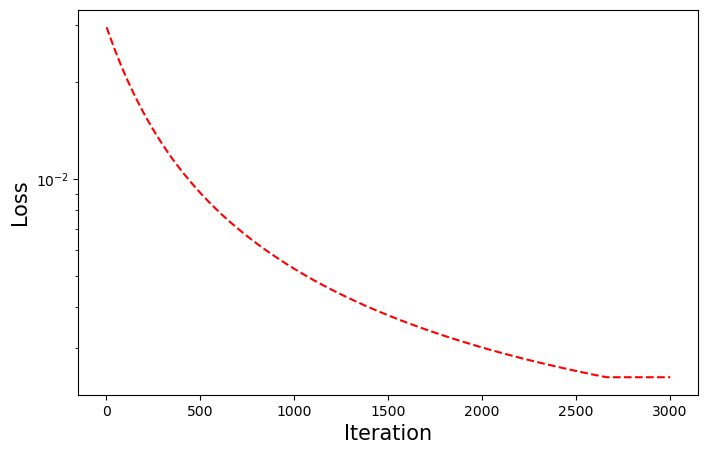

In [25]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(losses)+1),losses,'r--')
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.show()

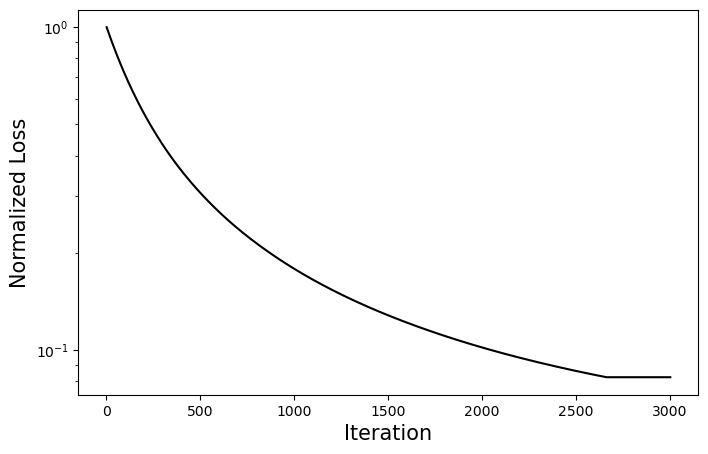

In [26]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(norm_losses)+1),norm_losses,'k-')
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)

plt.show()

In [27]:
vel()

Parameter containing:
tensor([[1.5001, 1.5408, 1.5816,  ..., 3.4184, 3.4592, 3.5000],
        [1.5014, 1.5421, 1.5823,  ..., 3.4184, 3.4592, 3.5000],
        [1.5142, 1.5503, 1.5866,  ..., 3.4184, 3.4592, 3.5000],
        ...,
        [1.5000, 1.5408, 1.5816,  ..., 3.4184, 3.4592, 3.5000],
        [1.5000, 1.5408, 1.5816,  ..., 3.4184, 3.4592, 3.5000],
        [1.5000, 1.5408, 1.5816,  ..., 3.4184, 3.4592, 3.5000]],
       dtype=torch.float64, requires_grad=True)

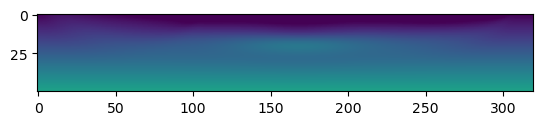

In [28]:
plt.imshow(vel().detach().numpy().T, vmin=1.5, vmax=5.0)

In [29]:
ssim = SSIM()

In [30]:
#plt.figure(figsize=[12,4])
#plt.ylim([0.1, 6])
#plt.xlabel('Distance (km)', fontsize=15)
#plt.ylabel('Time (s)', fontsize=15)
#plt.plot(ttime_obs[0], "k.", label="1st source")
#plt.plot(ttime_obs[49], "k.", label="50th source")
#plt.plot(ttime_obs[99], "k.", label="100th source")
#plt.plot(ttime_obs[149], "k.", label="150th source")
#plt.plot(ttime_obs[199], "k.", label="200th source")
#plt.legend(loc="upper right")

In [31]:
ax = np.arange(0, 320)

In [32]:
ax[ttime_obs[0]>0]

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101])

In [33]:
ttime_obs[0,ttime_obs[0]>0]

tensor([5.1283, 5.1078, 5.0835, 5.0564, 5.0275, 4.9972, 4.9659, 4.9341, 4.9017,
        4.8689, 4.8359, 4.8025, 4.7688, 4.7349, 4.7007, 4.6661, 4.6313, 4.5961,
        4.5606, 4.5248, 4.4886, 4.4521, 4.4152, 4.3780, 4.3404, 4.3024, 4.2641,
        4.2254, 4.1864, 4.1470, 4.1073, 4.0672, 4.0269, 3.9862, 3.9453, 3.9041,
        3.8626, 3.8209, 3.7789, 3.7367, 3.6942, 3.6515, 3.6085, 3.5653, 3.5219,
        3.4781, 3.4341, 3.3897, 3.3449, 3.2997, 3.2539, 3.2077, 3.1607, 3.1131,
        3.0646, 3.0152, 2.9648, 2.9133, 2.8605, 2.8065, 2.7511, 2.6942, 2.6359,
        2.5762, 2.5150, 2.4525, 2.3888, 2.3239, 2.2580, 2.1912, 2.1237, 2.0557,
        1.9872, 1.9185, 1.8497, 1.7808, 1.7120, 1.6434, 1.5750, 1.5068, 1.4390,
        1.3715, 1.3043, 1.2375, 1.1710, 1.1049, 1.0391, 0.9737, 0.9086, 0.8439,
        0.7794, 0.7153, 0.6515, 0.5880, 0.5248, 0.4621, 0.3999, 0.3385, 0.2784,
        0.2203])

([<matplotlib.axis.XTick at 0x7f611b0dc820>,
 [Text(0, 0, '0'),
  Text(50, 0, '5'),
  Text(100, 0, '10'),
  Text(150, 0, '15'),
  Text(200, 0, '20'),
  Text(250, 0, '25'),
  Text(300, 0, '30')])

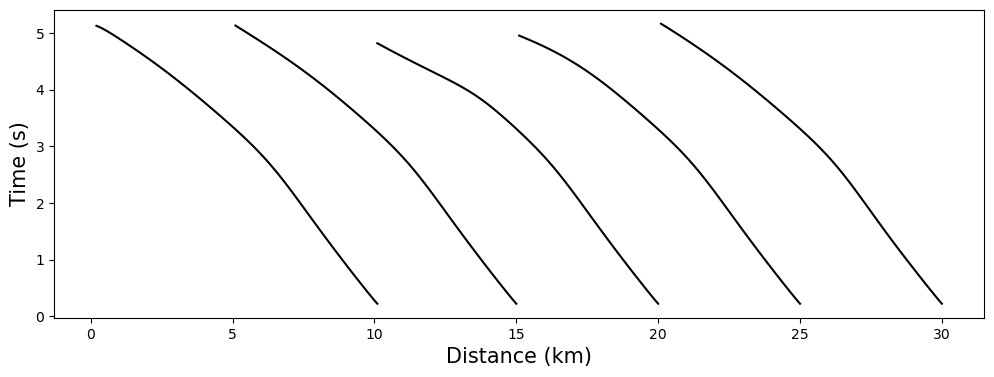

In [34]:
plt.figure(figsize=[12,4])
plt.xlabel('Distance (km)', fontsize=15)
plt.ylabel('Time (s)', fontsize=15)
plt.plot(ax[ttime_obs[0]>0], ttime_obs[0,ttime_obs[0]>0], "k-")
plt.plot(ax[ttime_obs[49]>0], ttime_obs[49,ttime_obs[49]>0], "k-")
plt.plot(ax[ttime_obs[99]>0], ttime_obs[99,ttime_obs[99]>0], "k-")
plt.plot(ax[ttime_obs[149]>0], ttime_obs[149,ttime_obs[149]>0], "k-")
plt.plot(ax[ttime_obs[199]>0], ttime_obs[199,ttime_obs[199]>0], "k-")
plt.xticks(np.arange(0, 320, 50), np.arange(0, 32, 5))

In [35]:
def evaluate(ttime_obs, vel,vtrue):
    since = time.time()
    
    test_mae = 0.0
    test_mse = 0.0
    test_ssim = 0.0
    test_loss = 0.0
    
    tomo.factorize(omega, vel())
    ttime = tomo.forward(torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    tr_loss = torch.sum((ttime_obs - ttime).abs())/(nshot*100)
    #tr_loss = F.l1_loss(ttime, ttime_obs)
    
    vel = vel().reshape(1,1,320,50)
    if vel.type() != vtrue.type():
        vtrue = vtrue.double()
    vtrue = vtrue.reshape(1,1,320,50)

    mae_loss = F.l1_loss(vel, vtrue)
    mse_loss = F.mse_loss(vel, vtrue)
    ssim_loss = ssim(vel, vtrue)
    loss = mae_loss + mse_loss + (1 - ssim_loss)
    
    time_elapsed = time.time() - since
    print('Traveltime MAE: {:.10f} Loss: {:.4f} MAE: {:.4f} MSE {:.4f} SSIM {:.4f}'.format(
        tr_loss, loss, mae_loss, mse_loss, ssim_loss))
    print('Total time elapesd of test data {:.0f}ms'.format(
        time_elapsed))
    return tr_loss, loss, mae_loss, mse_loss, ssim_loss

In [36]:
vtrue = np.load("../../data/ml_vel/vel%05d.npy"%ivel)
vtrue.shape = (nx,ny)

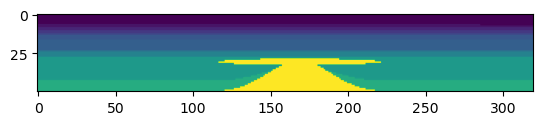

In [37]:
plt.imshow(vtrue.T)

In [38]:
vtrue = torch.from_numpy(vtrue)

In [39]:
vtrue.type()

'torch.FloatTensor'

In [40]:
vel().type()

'torch.DoubleTensor'

In [41]:
tr_loss, test_loss, test_mae, test_mse, test_ssim= evaluate(ttime_obs, vel, vtrue)

Traveltime MAE: 0.0289522223 Loss: 0.9138 MAE: 0.2674 MSE 0.2343 SSIM 0.5879
Total time elapesd of test data 1ms


In [42]:
tr_loss, test_loss, test_mae, test_mse, test_ssim

(tensor(0.0290, grad_fn=<DivBackward0>),
 tensor(0.9138, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.2674, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2343, dtype=torch.float64, grad_fn=<MseLossBackward0>),
 tensor(0.5879, dtype=torch.float64, grad_fn=<MeanBackward0>))

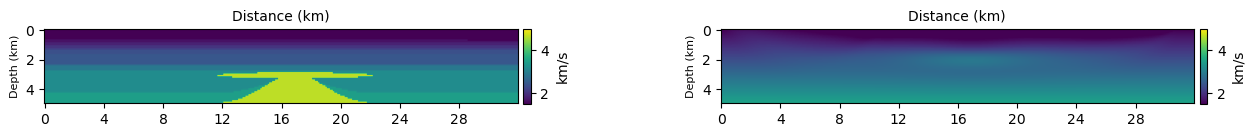

In [43]:
plt.figure(figsize=[16,3])
plt.subplot(1,2,1)
plt.imshow(vtrue.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.title("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")
plt.subplot(1,2,2)
plt.imshow(vel().detach().numpy().T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.title("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [44]:
prediction = np.load("./prediction%05d.npy"%ivel)
prediction.shape = (320,50)

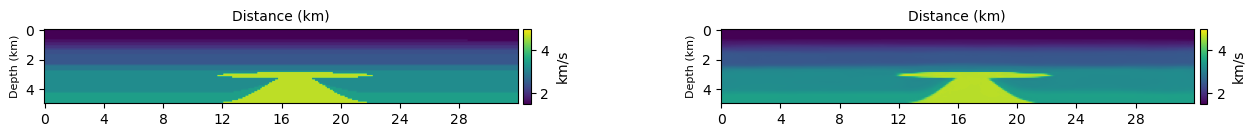

In [45]:
plt.figure(figsize=[16,3])
plt.subplot(1,2,1)
plt.imshow(vtrue.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.title("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")
plt.subplot(1,2,2)
plt.imshow(prediction.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.title("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [46]:
def plot_traveltime(ttime_obs, vel_tomo,vel_dl):
    
    tomo.factorize(omega, vel_tomo())
    ttime_tomo = tomo.forward(torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    tomo.factorize(omega, vel_dl())
    ttime_dl = tomo.forward(torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    plt.figure(figsize=[12,4])
    plt.xlabel('Distance (km)', fontsize=15)
    plt.ylabel('Time (s)', fontsize=15)
    plt.plot(ax[ttime_obs[0]>0], ttime_obs[0,ttime_obs[0]>0], "r-", label="observed")
    plt.plot(ax[ttime_tomo[0].detach().numpy()>0], ttime_tomo[0,ttime_tomo[0]>0].detach().numpy(), "b--", label="modeled_tomo")
    plt.plot(ax[ttime_dl[0].detach().numpy()>0], ttime_dl[0,ttime_dl[0]>0].detach().numpy(), "c-.", label="modeled_dl")
    plt.legend(loc="upper right")
    
    plt.plot(ax[ttime_obs[49]>0], ttime_obs[49,ttime_obs[49]>0], "r-", label="observed")
    plt.plot(ax[ttime_tomo[49].detach().numpy()>0], ttime_tomo[49,ttime_tomo[49]>0].detach().numpy(), "b--", label="modeled_tomo")
    plt.plot(ax[ttime_dl[49].detach().numpy()>0], ttime_dl[49,ttime_dl[49]>0].detach().numpy(), "c-.", label="modeled_dl")
    
    plt.plot(ax[ttime_obs[99]>0], ttime_obs[99,ttime_obs[99]>0], "r-", label="observed")
    plt.plot(ax[ttime_tomo[99].detach().numpy()>0], ttime_tomo[99,ttime_tomo[99]>0].detach().numpy(), "b--", label="modeled_tomo")
    plt.plot(ax[ttime_dl[99].detach().numpy()>0], ttime_dl[99,ttime_dl[99]>0].detach().numpy(), "c-.", label="modeled_dl")
   
    plt.plot(ax[ttime_obs[149]>0], ttime_obs[149,ttime_obs[149]>0], "r-", label="observed")
    plt.plot(ax[ttime_tomo[149].detach().numpy()>0], ttime_tomo[149,ttime_tomo[149]>0].detach().numpy(), "b--", label="modeled_tomo")
    plt.plot(ax[ttime_dl[149].detach().numpy()>0], ttime_dl[149,ttime_dl[149]>0].detach().numpy(), "c-.", label="modeled_dl")
    
    plt.plot(ax[ttime_obs[199]>0], ttime_obs[199,ttime_obs[199]>0], "r-", label="observed")
    plt.plot(ax[ttime_tomo[199].detach().numpy()>0], ttime_tomo[199,ttime_tomo[199]>0].detach().numpy(), "b--", label="modeled_tomo")
    plt.plot(ax[ttime_dl[199].detach().numpy()>0], ttime_dl[199,ttime_dl[199]>0].detach().numpy(), "c-.", label="modeled_dl")
    plt.xticks(np.arange(0, 320, 50), np.arange(0, 32, 5))

In [47]:
vel_dl = param_selector('velocity',prediction,vmin,vmax)

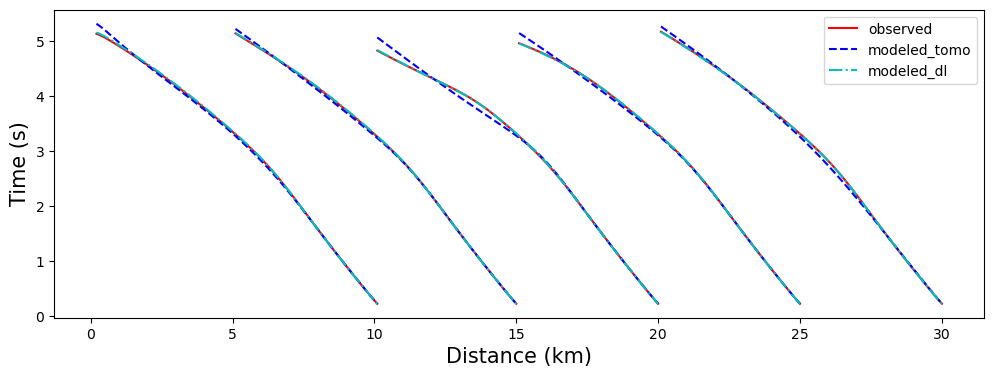

In [48]:
plot_traveltime(ttime_obs, vel,vel_dl)

In [49]:
tr_loss, test_loss, test_mae, test_mse, test_ssim= evaluate(ttime_obs, vel_dl, vtrue)

Traveltime MAE: 0.0040890914 Loss: 0.1692 MAE: 0.0445 MSE 0.0138 SSIM 0.8891
Total time elapesd of test data 1ms


In [50]:
tr_loss, test_loss, test_mae, test_mse, test_ssim

(tensor(0.0041, grad_fn=<DivBackward0>),
 tensor(0.1692, grad_fn=<AddBackward0>),
 tensor(0.0445, grad_fn=<MeanBackward0>),
 tensor(0.0138, grad_fn=<MseLossBackward0>),
 tensor(0.8891, grad_fn=<MeanBackward0>))